# 03 - Noise Anatomy

GeoSim models three independent noise sources that corrupt clean physics signals:

1. **Sensor noise** — white + 1/f electronic noise from fluxgate magnetometers
2. **Diurnal drift** — slow geomagnetic variation from ionospheric currents
3. **Heading error** — orientation-dependent systematic bias

This notebook dissects each source individually, examines spectral properties,
then combines them to study detection limits under realistic conditions.

**Scenario:** `single-ferrous-target.json`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from geosim.noise.models import (
    SensorNoise, DiurnalDrift, HeadingError, NoiseModel,
    pathfinder_noise_model, hirt_fdem_noise_model,
)
from geosim.magnetics.dipole import (
    dipole_moment_from_sphere, gradiometer_reading, detection_depth_estimate,
)
from geosim.scenarios.loader import load_scenario

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Sensor Noise: White + 1/f

Fluxgate magnetometers exhibit two noise regimes:
- **White noise** (flat PSD) above the corner frequency — electronic thermal noise
- **1/f (pink) noise** below the corner — drift, bias instability

The `SensorNoise` dataclass models both via spectral shaping.

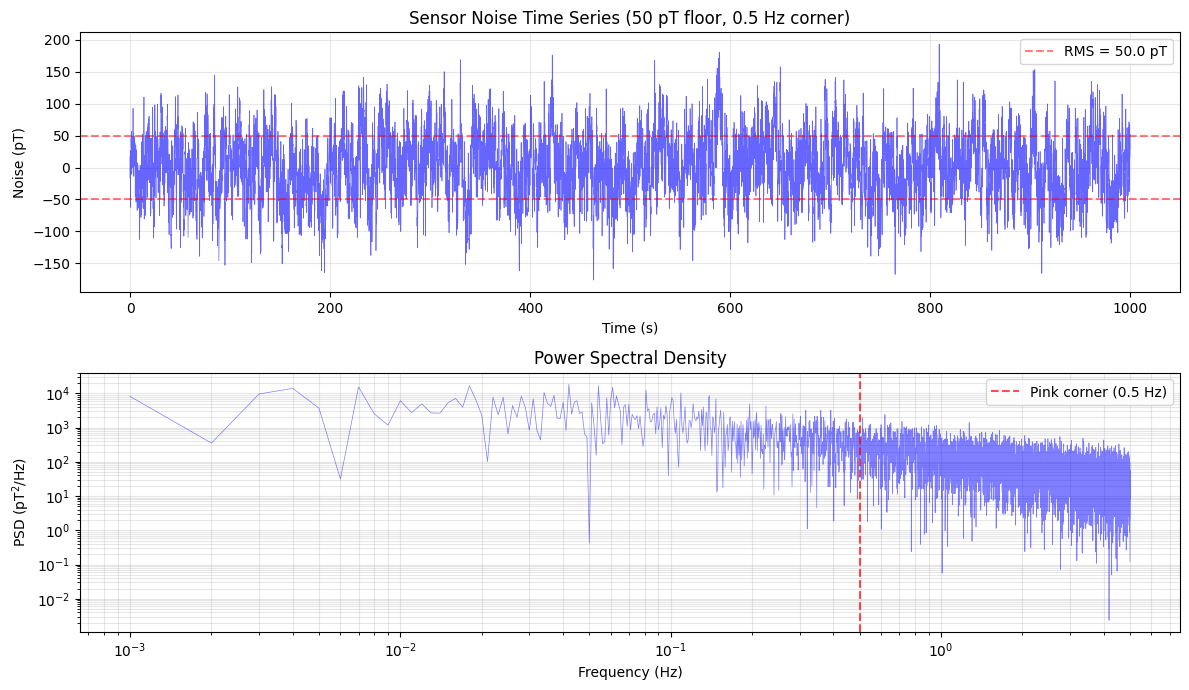

In [2]:
rng = np.random.default_rng(42)
n_samples = 10000
sample_rate = 10.0  # Hz (Pathfinder default)

sensor = SensorNoise(noise_floor=50e-12, pink_corner=0.5)  # 50 pT, 0.5 Hz corner
noise = sensor.generate(n_samples, sample_rate, rng)

t = np.arange(n_samples) / sample_rate

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))

# Time series
ax1.plot(t, noise * 1e12, 'b-', alpha=0.6, lw=0.5)
ax1.axhline(50, color='r', ls='--', alpha=0.5, label=f'RMS = {np.std(noise)*1e12:.1f} pT')
ax1.axhline(-50, color='r', ls='--', alpha=0.5)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Noise (pT)')
ax1.set_title('Sensor Noise Time Series (50 pT floor, 0.5 Hz corner)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Power spectral density
freqs = np.fft.rfftfreq(n_samples, 1.0 / sample_rate)
psd = np.abs(np.fft.rfft(noise))**2 / (n_samples * sample_rate) * 1e24  # pT^2/Hz
ax2.loglog(freqs[1:], psd[1:], 'b-', alpha=0.5, lw=0.5)
ax2.axvline(0.5, color='r', ls='--', alpha=0.7, label='Pink corner (0.5 Hz)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD (pT$^2$/Hz)')
ax2.set_title('Power Spectral Density')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()

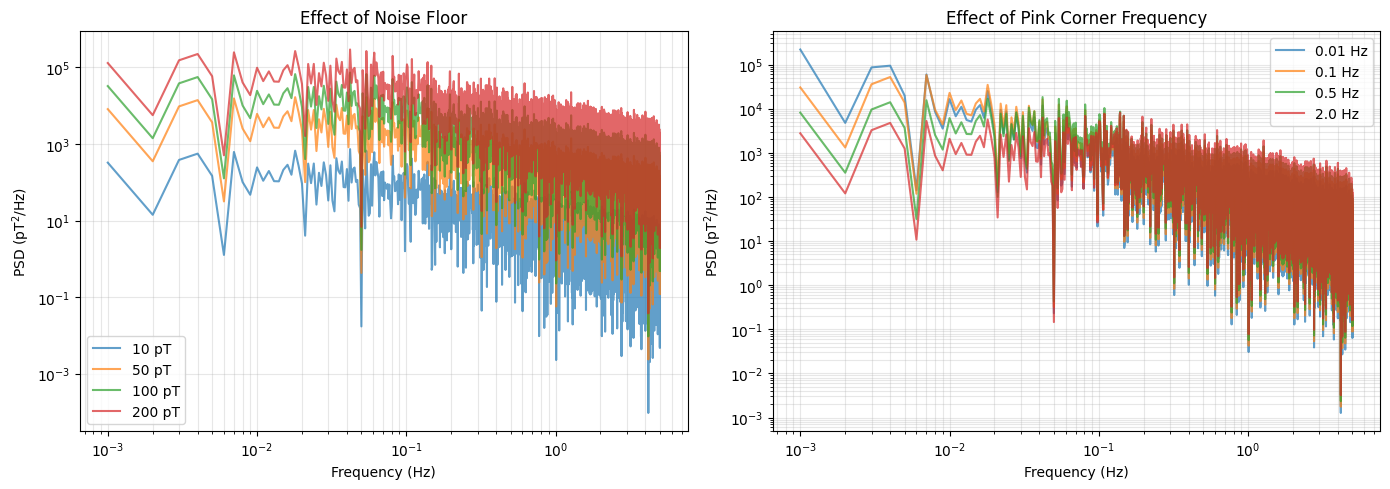

In [3]:
# Parameter sweep: vary noise floor and pink corner
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sweep noise floor
for floor_pT in [10, 50, 100, 200]:
    s = SensorNoise(noise_floor=floor_pT * 1e-12, pink_corner=0.5)
    n = s.generate(n_samples, sample_rate, np.random.default_rng(42))
    f = np.fft.rfftfreq(n_samples, 1.0 / sample_rate)
    p = np.abs(np.fft.rfft(n))**2 / (n_samples * sample_rate) * 1e24
    ax1.loglog(f[1:], p[1:], alpha=0.7, label=f'{floor_pT} pT')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('PSD (pT$^2$/Hz)')
ax1.set_title('Effect of Noise Floor')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Sweep pink corner
for corner in [0.01, 0.1, 0.5, 2.0]:
    s = SensorNoise(noise_floor=50e-12, pink_corner=corner)
    n = s.generate(n_samples, sample_rate, np.random.default_rng(42))
    f = np.fft.rfftfreq(n_samples, 1.0 / sample_rate)
    p = np.abs(np.fft.rfft(n))**2 / (n_samples * sample_rate) * 1e24
    ax2.loglog(f[1:], p[1:], alpha=0.7, label=f'{corner} Hz')

ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD (pT$^2$/Hz)')
ax2.set_title('Effect of Pink Corner Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()

## 2. Diurnal Drift

The Earth's field varies ~20–100 nT over 24 hours due to ionospheric currents.
A gradiometer **rejects** most of this common-mode drift, but imperfect sensor
matching leaves a small residual. The `DiurnalDrift` model applies a sinusoidal
variation scaled by a `rejection_ratio`.

Rejection ratio        Residual peak (nT)
------------------------------------------
1.000                              50.000
0.100                               5.000
0.010                               0.500
0.001                               0.050


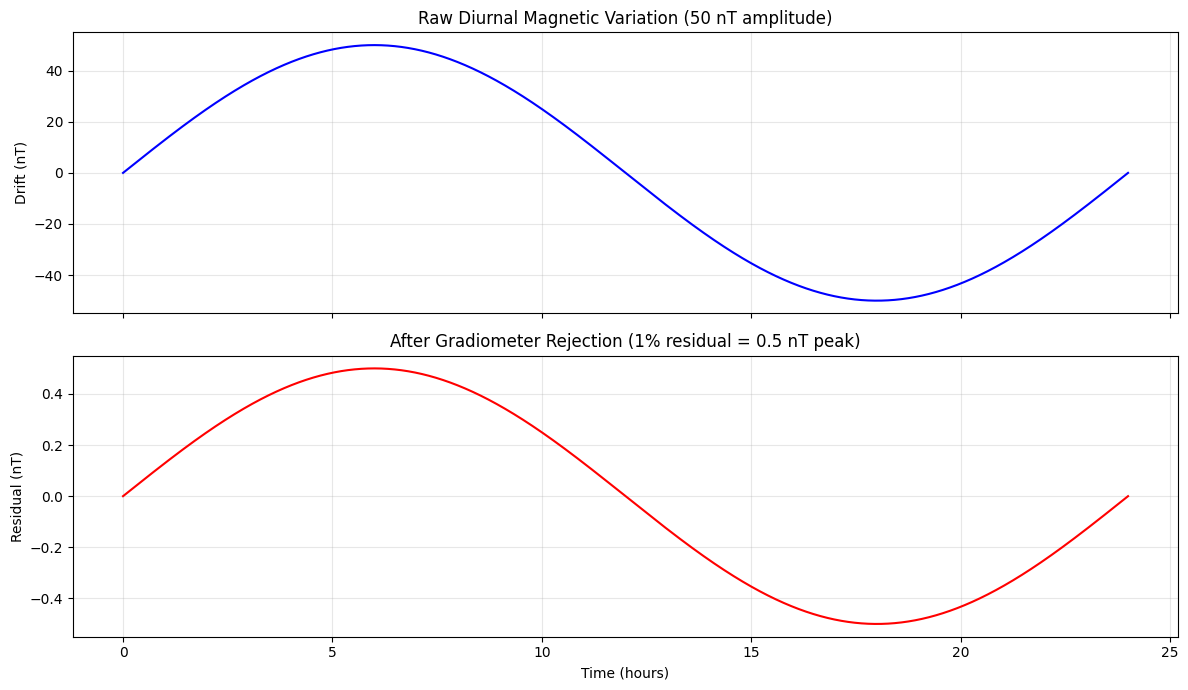

In [4]:
# Show raw drift and gradiometer-rejected residual
drift = DiurnalDrift(amplitude=50e-9, period=86400.0, rejection_ratio=0.01)

# 24-hour survey timeline
t_24h = np.linspace(0, 86400, 10000)
raw_drift = drift.amplitude * np.sin(2.0 * np.pi * t_24h / drift.period)
rejected_drift = drift.evaluate(t_24h)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1.plot(t_24h / 3600, raw_drift * 1e9, 'b-', lw=1.5)
ax1.set_ylabel('Drift (nT)')
ax1.set_title('Raw Diurnal Magnetic Variation (50 nT amplitude)')
ax1.grid(True, alpha=0.3)

ax2.plot(t_24h / 3600, rejected_drift * 1e9, 'r-', lw=1.5)
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Residual (nT)')
ax2.set_title(f'After Gradiometer Rejection ({drift.rejection_ratio:.0%} residual = {drift.amplitude * drift.rejection_ratio * 1e9:.1f} nT peak)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Rejection ratio comparison
print(f"{'Rejection ratio':<20} {'Residual peak (nT)':>20}")
print('-' * 42)
for rr in [1.0, 0.1, 0.01, 0.001]:
    d = DiurnalDrift(amplitude=50e-9, rejection_ratio=rr)
    peak = d.amplitude * rr * 1e9
    print(f"{rr:<20.3f} {peak:>20.3f}")

## 3. Heading Error

Fluxgate sensors have a small sensitivity to orientation relative to the Earth's
field. This produces a **systematic** error pattern: `sin(2θ)` where θ is heading.
In a zigzag survey, alternating line directions create visible striping artifacts.

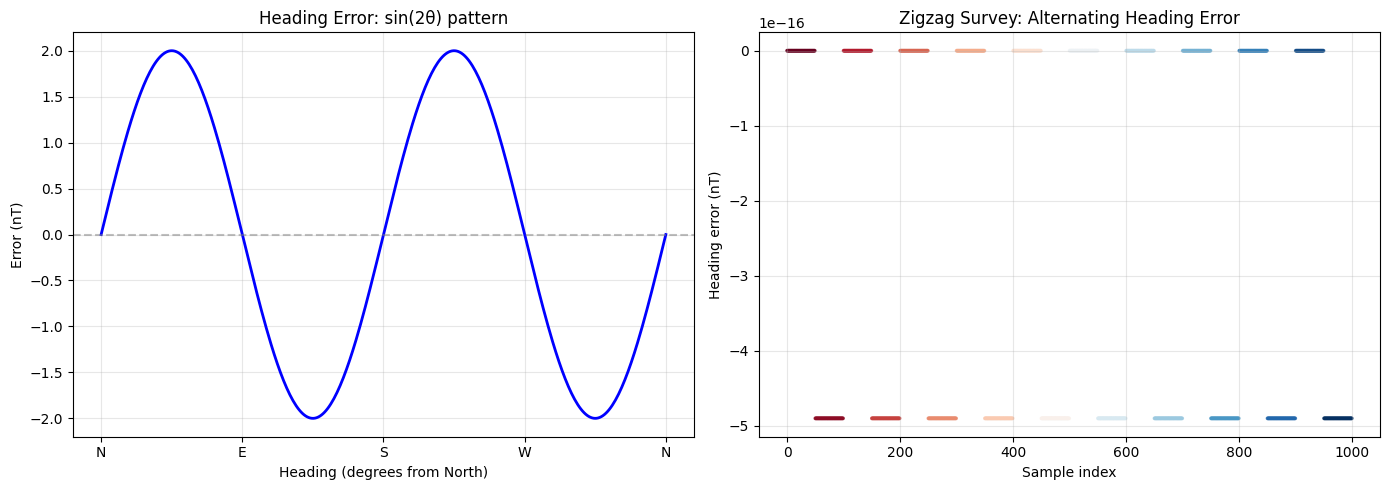

In [5]:
heading_err = HeadingError(amplitude=2e-9)  # 2 nT peak

# Full compass sweep
theta = np.linspace(0, 2 * np.pi, 360)
error = heading_err.evaluate(theta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Cartesian plot
ax1.plot(np.degrees(theta), error * 1e9, 'b-', lw=2)
ax1.set_xlabel('Heading (degrees from North)')
ax1.set_ylabel('Error (nT)')
ax1.set_title('Heading Error: sin(2\u03b8) pattern')
ax1.set_xticks([0, 90, 180, 270, 360])
ax1.set_xticklabels(['N', 'E', 'S', 'W', 'N'])
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='gray', ls='--', alpha=0.5)

# Simulate zigzag heading effect
n_lines = 20
headings_zigzag = np.array(
    [0.0 if i % 2 == 0 else np.pi for i in range(n_lines) for _ in range(50)]
)
heading_noise = heading_err.evaluate(headings_zigzag)
line_idx = np.repeat(np.arange(n_lines), 50)

ax2.scatter(np.arange(len(headings_zigzag)), heading_noise * 1e9,
            c=line_idx, cmap='RdBu', s=3, alpha=0.7)
ax2.set_xlabel('Sample index')
ax2.set_ylabel('Heading error (nT)')
ax2.set_title('Zigzag Survey: Alternating Heading Error')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

## 4. Combined Noise Model

The `NoiseModel` aggregates all three sources. Let's compare the Pathfinder
(surface walking) and HIRT FDEM (stationary borehole) noise profiles.

In [6]:
pf_model = pathfinder_noise_model()
hirt_model = hirt_fdem_noise_model()

print('Pathfinder noise model:')
print(f'  Sensor floor: {pf_model.sensor.noise_floor*1e12:.0f} pT, pink corner: {pf_model.sensor.pink_corner} Hz')
print(f'  Diurnal: {pf_model.diurnal.amplitude*1e9:.0f} nT, rejection: {pf_model.diurnal.rejection_ratio}')
print(f'  Heading: {pf_model.heading.amplitude*1e9:.0f} nT')
print()
print('HIRT FDEM noise model:')
print(f'  Sensor floor: {hirt_model.sensor.noise_floor:.1e}, pink corner: {hirt_model.sensor.pink_corner} Hz')
print(f'  Diurnal: {hirt_model.diurnal.amplitude*1e9:.0f} nT, rejection: {hirt_model.diurnal.rejection_ratio}')
print(f'  Heading: {hirt_model.heading.amplitude*1e9:.0f} nT (stationary = no heading error)')

Pathfinder noise model:
  Sensor floor: 50 pT, pink corner: 0.5 Hz
  Diurnal: 50 nT, rejection: 0.01
  Heading: 2 nT

HIRT FDEM noise model:
  Sensor floor: 1.0e-04, pink corner: 0.1 Hz
  Diurnal: 50 nT, rejection: 0.001
  Heading: 0 nT (stationary = no heading error)


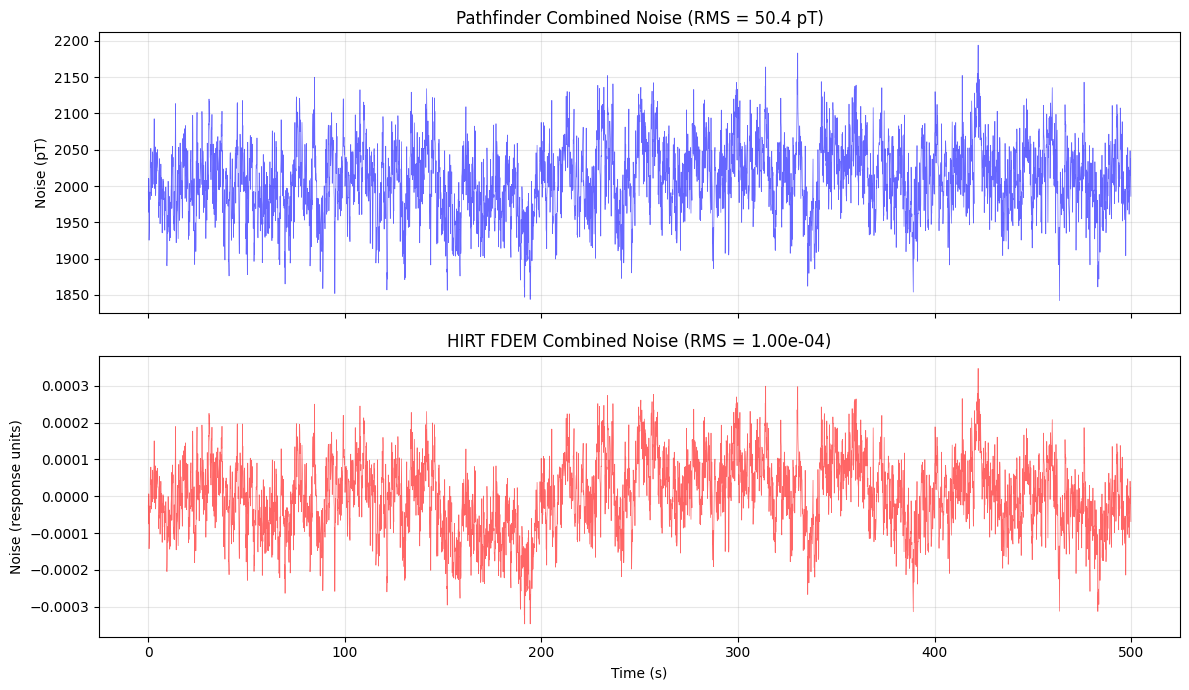

In [7]:
# Apply both models to a clean signal and compare
rng_pf = np.random.default_rng(42)
rng_hirt = np.random.default_rng(42)

n = 5000
t = np.arange(n) / sample_rate
headings = np.full(n, np.pi / 4)  # 45 deg heading
clean = np.zeros(n)

noisy_pf = pf_model.apply(clean, t, headings, sample_rate, rng_pf)
noisy_hirt = hirt_model.apply(clean, t, headings, sample_rate, rng_hirt)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1.plot(t, noisy_pf * 1e12, 'b-', alpha=0.6, lw=0.5)
ax1.set_ylabel('Noise (pT)')
ax1.set_title(f'Pathfinder Combined Noise (RMS = {np.std(noisy_pf)*1e12:.1f} pT)')
ax1.grid(True, alpha=0.3)

ax2.plot(t, noisy_hirt, 'r-', alpha=0.6, lw=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Noise (response units)')
ax2.set_title(f'HIRT FDEM Combined Noise (RMS = {np.std(noisy_hirt):.2e})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

## 5. SNR vs Depth

How does noise affect detection at different depths? The dipole gradient signal
decays as ~1/r^4, while noise is constant. Let's compute the signal-to-noise
ratio as a function of target depth for a 50mm steel sphere.

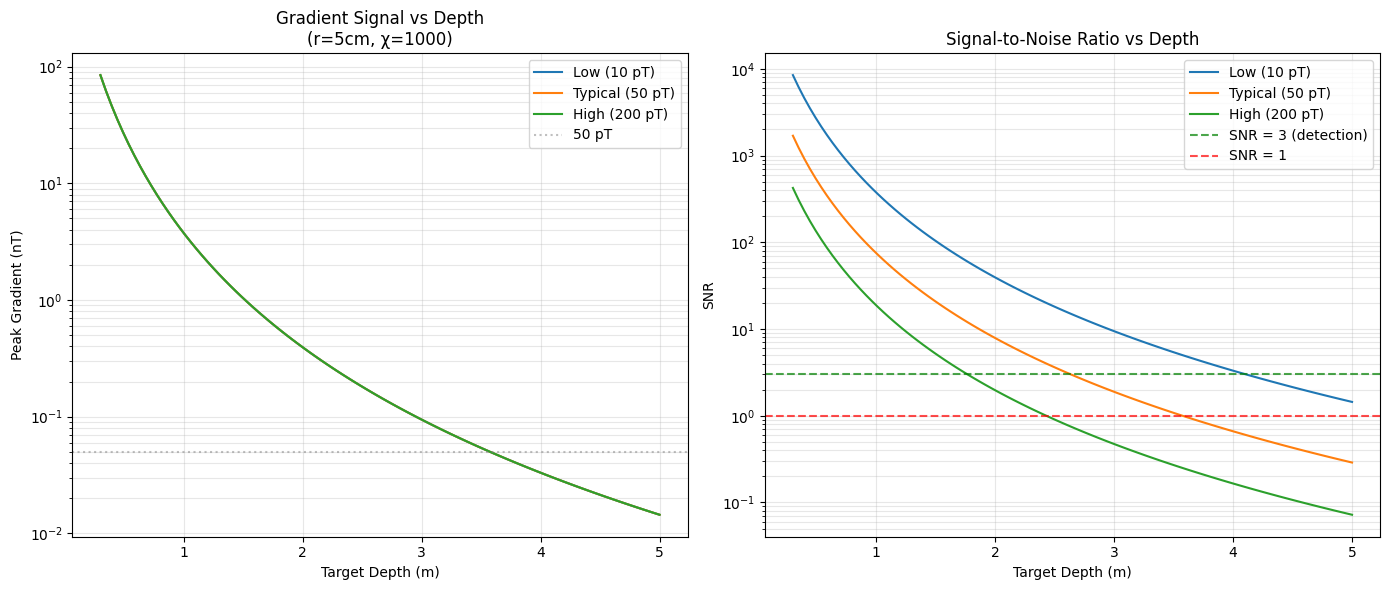

In [8]:
# Load scenario for realistic parameters
scenario = load_scenario(Path('..') / 'scenarios' / 'single-ferrous-target.json')
obj = scenario.objects[0]
moment = obj.moment
m_mag = np.linalg.norm(moment)

# Sweep target depth
depths = np.linspace(0.3, 5.0, 100)
noise_levels = {'Low (10 pT)': 10e-12, 'Typical (50 pT)': 50e-12, 'High (200 pT)': 200e-12}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for label, noise_floor in noise_levels.items():
    peak_gradients = []
    for d in depths:
        target_pos = np.array([0.0, 0.0, -d])
        r_obs = np.array([[0.0, 0.0, 0.175]])
        _, _, grad = gradiometer_reading(
            r_obs, [{'position': target_pos, 'moment': moment}],
            sensor_separation=0.35,
        )
        peak_gradients.append(abs(grad[0]))

    peak_gradients = np.array(peak_gradients)
    snr = peak_gradients / noise_floor

    ax1.semilogy(depths, peak_gradients * 1e9, label=label)
    ax2.semilogy(depths, snr, label=label)

ax1.axhline(50e-12 * 1e9, color='gray', ls=':', alpha=0.5, label='50 pT')
ax1.set_xlabel('Target Depth (m)')
ax1.set_ylabel('Peak Gradient (nT)')
ax1.set_title(f'Gradient Signal vs Depth\n(r={obj.radius*100:.0f}cm, \u03c7={obj.susceptibility:.0f})')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

ax2.axhline(3.0, color='green', ls='--', alpha=0.7, label='SNR = 3 (detection)')
ax2.axhline(1.0, color='red', ls='--', alpha=0.7, label='SNR = 1')
ax2.set_xlabel('Target Depth (m)')
ax2.set_ylabel('SNR')
ax2.set_title('Signal-to-Noise Ratio vs Depth')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()

## 6. Detection Threshold Curves

For different noise floors, what is the maximum detectable depth as a function
of target moment? This uses `detection_depth_estimate()` from the dipole module.

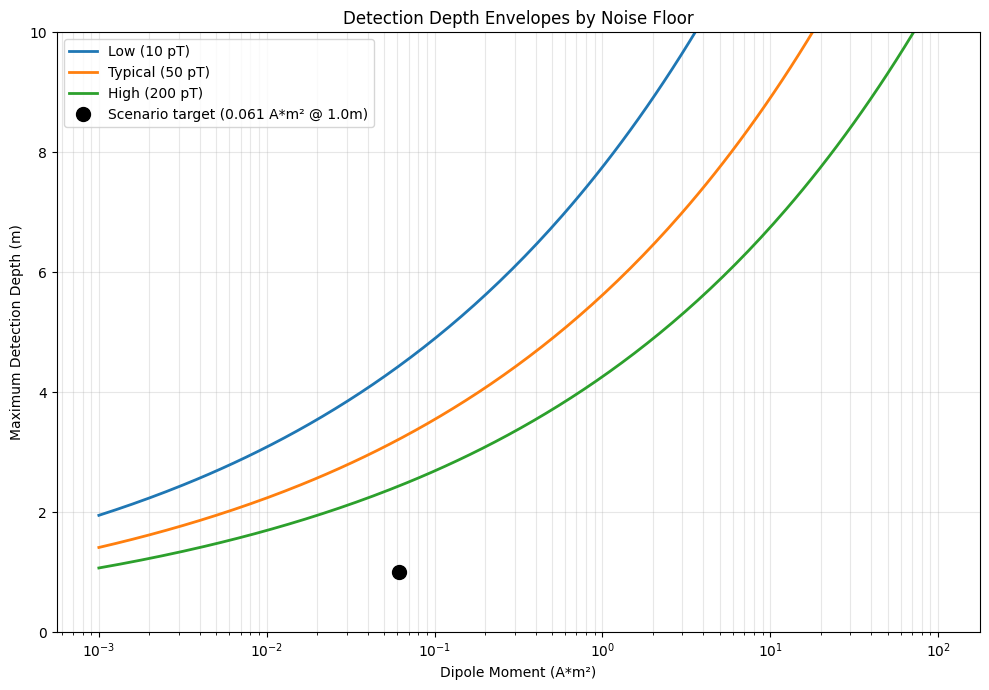

In [9]:
moments = np.logspace(-3, 2, 200)  # 0.001 to 100 A*m^2

fig, ax = plt.subplots(figsize=(10, 7))

for label, noise_floor in noise_levels.items():
    depths_est = [detection_depth_estimate(m, noise_floor, 0.35) for m in moments]
    ax.semilogx(moments, depths_est, lw=2, label=label)

# Mark the scenario target
ax.plot(m_mag, abs(obj.position[2]), 'ko', markersize=10, zorder=5,
        label=f'Scenario target ({m_mag:.3f} A*m\u00b2 @ {abs(obj.position[2])}m)')

ax.set_xlabel('Dipole Moment (A*m\u00b2)')
ax.set_ylabel('Maximum Detection Depth (m)')
ax.set_title('Detection Depth Envelopes by Noise Floor')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
ax.set_ylim(0, 10)

plt.tight_layout()

## 7. Monte Carlo Detection Probability

Detection isn't binary — noise creates randomness. Let's run 100 noisy realizations
and compute the probability of detecting the target at various depths.

Detection criterion: peak |gradient| > 3× noise floor (SNR > 3).

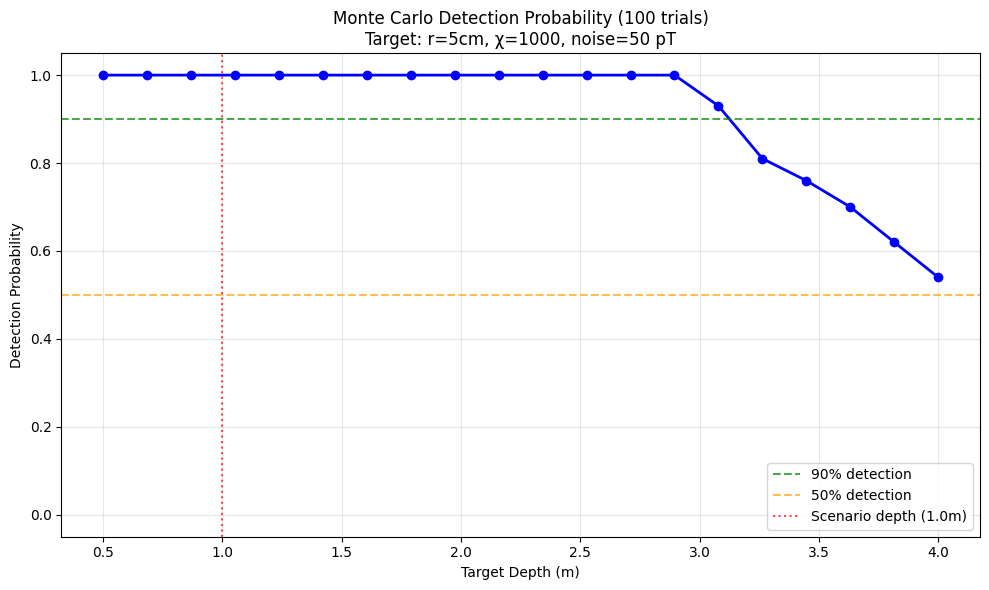

In [10]:
n_trials = 100
test_depths = np.linspace(0.5, 4.0, 20)
noise_floor_pf = 50e-12
detection_threshold = 3.0 * noise_floor_pf

pf_noise = pathfinder_noise_model()
n_profile = 200
x_profile = np.linspace(-3, 3, n_profile)
t_profile = np.arange(n_profile) / 10.0
h_profile = np.zeros(n_profile)

detection_prob = []

for depth in test_depths:
    detections = 0
    target_pos = np.array([0.0, 0.0, -depth])
    sources = [{'position': target_pos, 'moment': moment}]

    r_bottom = np.column_stack([
        x_profile, np.zeros(n_profile), np.full(n_profile, 0.175)
    ])
    _, _, clean_grad = gradiometer_reading(r_bottom, sources, 0.35)

    for trial in range(n_trials):
        rng_trial = np.random.default_rng(1000 + trial)
        noisy_grad = pf_noise.apply(
            clean_grad, t_profile, h_profile, 10.0, rng_trial
        )
        if np.max(np.abs(noisy_grad)) > detection_threshold:
            detections += 1

    detection_prob.append(detections / n_trials)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_depths, detection_prob, 'bo-', lw=2, markersize=6)
ax.axhline(0.9, color='green', ls='--', alpha=0.7, label='90% detection')
ax.axhline(0.5, color='orange', ls='--', alpha=0.7, label='50% detection')
ax.axvline(abs(obj.position[2]), color='red', ls=':', alpha=0.7,
           label=f'Scenario depth ({abs(obj.position[2])}m)')
ax.set_xlabel('Target Depth (m)')
ax.set_ylabel('Detection Probability')
ax.set_title(f'Monte Carlo Detection Probability ({n_trials} trials)\n'
             f'Target: r={obj.radius*100:.0f}cm, \u03c7={obj.susceptibility:.0f}, noise=50 pT')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()

## 8. Frequency-Domain Analysis

The dipole gradient signal has a characteristic spatial frequency content
(determined by target depth and survey speed). Noise has a different spectral
signature. Optimal filtering exploits this separation.

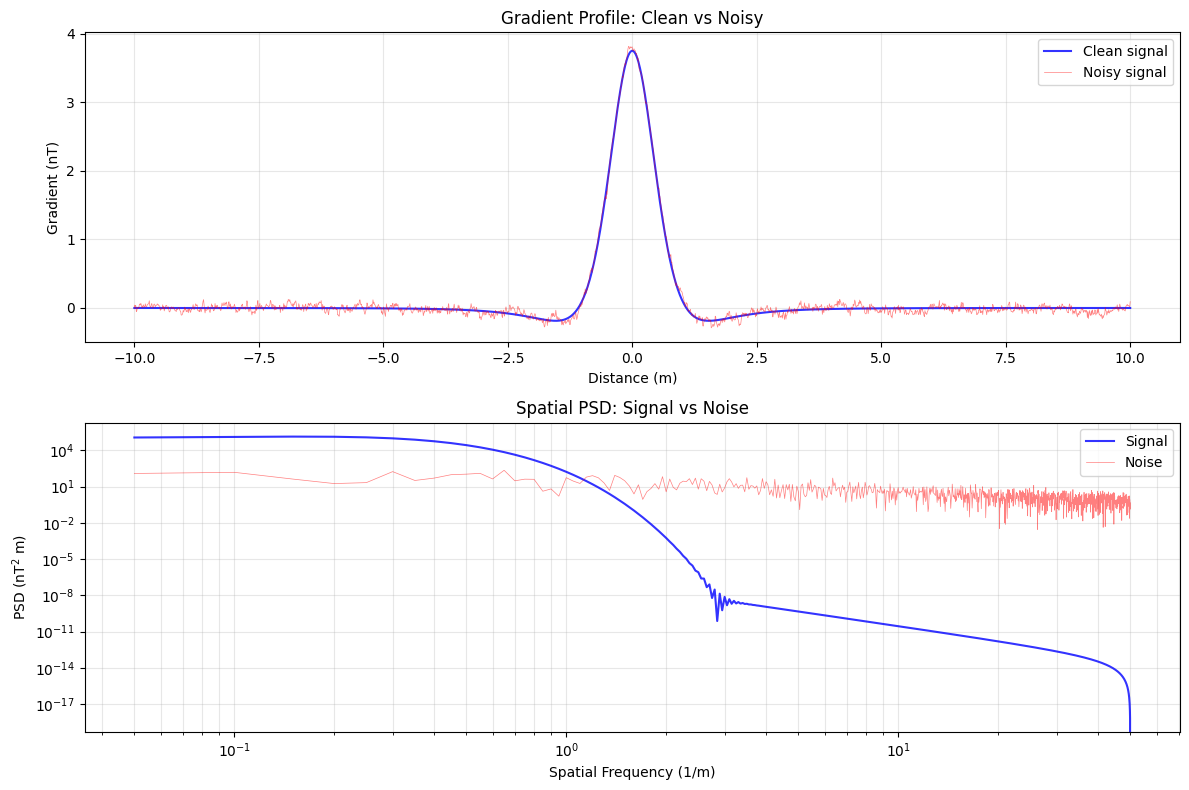

In [11]:
# Generate a realistic survey profile with and without noise
target_pos = np.array([0.0, 0.0, -1.0])  # 1m depth
sources = [{'position': target_pos, 'moment': moment}]

n_pts = 2000
speed = 1.0  # m/s
x = np.linspace(-10, 10, n_pts)
t_survey = np.abs(x) / speed
headings_survey = np.zeros(n_pts)

r_bottom = np.column_stack([x, np.zeros(n_pts), np.full(n_pts, 0.175)])
_, _, clean_grad = gradiometer_reading(r_bottom, sources, 0.35)

rng_freq = np.random.default_rng(42)
noisy_grad = pf_noise.apply(clean_grad, t_survey, headings_survey, 10.0, rng_freq)

# PSD comparison
freq_axis = np.fft.rfftfreq(n_pts, d=(x[1] - x[0]))  # spatial frequency (1/m)
psd_clean = np.abs(np.fft.rfft(clean_grad))**2
psd_noisy = np.abs(np.fft.rfft(noisy_grad))**2
psd_noise_only = np.abs(np.fft.rfft(noisy_grad - clean_grad))**2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(x, clean_grad * 1e9, 'b-', lw=1.5, label='Clean signal', alpha=0.8)
ax1.plot(x, noisy_grad * 1e9, 'r-', lw=0.5, label='Noisy signal', alpha=0.5)
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Gradient (nT)')
ax1.set_title('Gradient Profile: Clean vs Noisy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.loglog(freq_axis[1:], psd_clean[1:] * 1e18, 'b-', lw=1.5, label='Signal', alpha=0.8)
ax2.loglog(freq_axis[1:], psd_noise_only[1:] * 1e18, 'r-', lw=0.5, label='Noise', alpha=0.5)
ax2.set_xlabel('Spatial Frequency (1/m)')
ax2.set_ylabel('PSD (nT$^2$ m)')
ax2.set_title('Spatial PSD: Signal vs Noise')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()

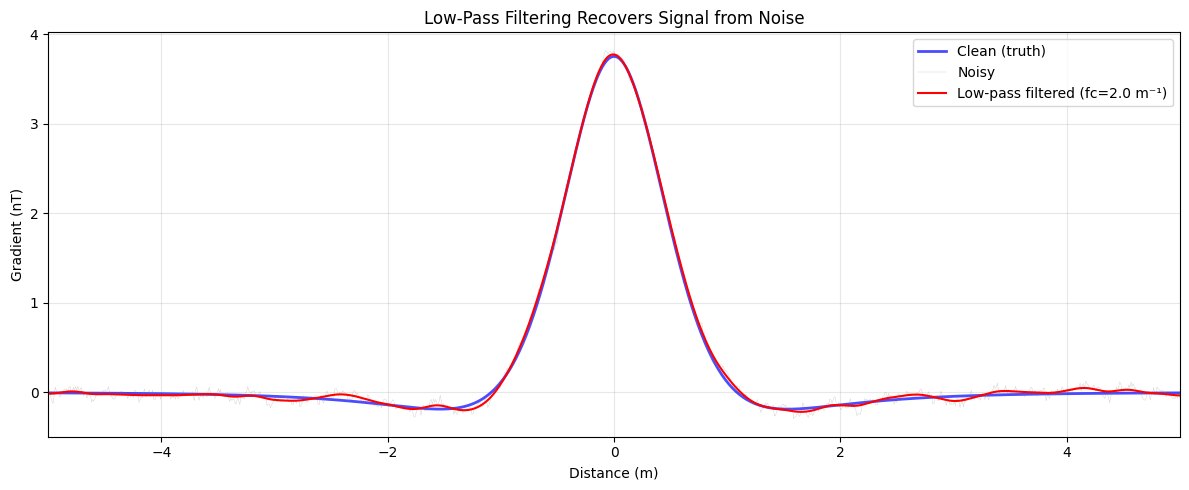

In [12]:
# Demonstrate low-pass filtering benefit
from numpy.fft import rfft, irfft, rfftfreq

# Spatial low-pass filter
cutoff_freq = 2.0  # 1/m
spatial_freqs = rfftfreq(n_pts, d=(x[1] - x[0]))
lpf = 1.0 / (1.0 + (spatial_freqs / cutoff_freq)**4)  # Butterworth-like

filtered_grad = irfft(rfft(noisy_grad) * lpf, n=n_pts)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, clean_grad * 1e9, 'b-', lw=2, label='Clean (truth)', alpha=0.7)
ax.plot(x, noisy_grad * 1e9, 'gray', lw=0.3, label='Noisy', alpha=0.4)
ax.plot(x, filtered_grad * 1e9, 'r-', lw=1.5, label=f'Low-pass filtered (fc={cutoff_freq} m\u207b\u00b9)')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Gradient (nT)')
ax.set_title('Low-Pass Filtering Recovers Signal from Noise')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 5)

plt.tight_layout()

## Key Takeaways

1. **Sensor noise** has two regimes: white (flat PSD) above the corner frequency and 1/f (rising) below it
2. **Diurnal drift** is large (~50 nT) but the gradiometer rejects >99% of it
3. **Heading error** produces systematic sin(2\u03b8) stripes in zigzag surveys
4. **HIRT FDEM** has no heading error (stationary probes) and better drift rejection
5. **SNR drops as ~1/r^4** — depth sensitivity is the fundamental challenge
6. **Monte Carlo** shows detection probability transitions from ~100% to ~0% over a narrow depth range
7. **Low-pass filtering** in the spatial domain can significantly improve SNR

Next: [04-em-induction-physics.ipynb](04-em-induction-physics.ipynb) — EM skin depth and FDEM forward models